## Nuscenes Setup

In [280]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points


nusc = NuScenes(version='v1.0-mini', dataroot='C:/Users/neel/MLPurdue/NuScenes/v1.0-mini', verbose=True)
helper = PredictHelper(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.292 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


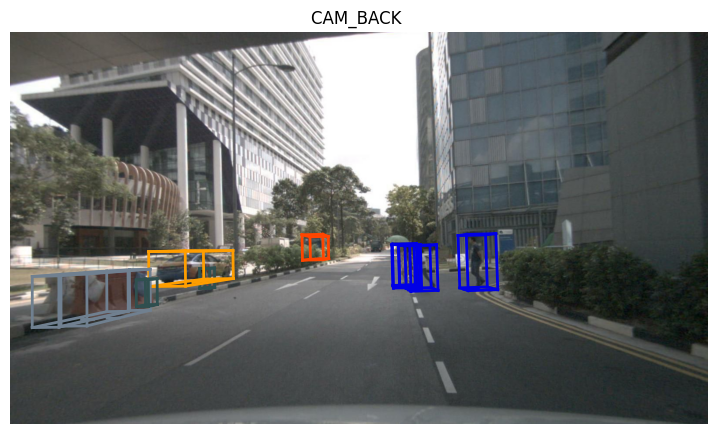

In [281]:
sample_token =  nusc.sample[0]['token']
sample = nusc.get('sample', sample_token)

sensor = 'CAM_BACK' 
cam_front_data = nusc.get('sample_data', sample['data'][sensor])
sensor_record = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])

cs_translation = np.array(sensor_record['translation'])
cs_rotation = Quaternion(sensor_record['rotation']).rotation_matrix  


nusc.render_sample_data(cam_front_data['token'])

data_path, current_boxes, camera_intrinsic = nusc.get_sample_data(cam_front_data['token'], box_vis_level=0, use_flat_vehicle_coordinates=False)
im = np.array(plt.imread(data_path))

In [282]:
ego_pose = nusc.get("ego_pose", cam_front_data['ego_pose_token'])
ego_translation = np.array(ego_pose['translation'])
ego_rotation = Quaternion(ego_pose['rotation']).rotation_matrix

In [283]:
movement_threshold = 1
all_future_boxes = []
for instance in nusc.instance:
    instance_token = instance['token']
    try:
        instance_future = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=True, just_xy=True)
    except KeyError as e:
        continue
        
    future_positions = np.array([state for state in instance_future])
    if len(future_positions) < 3:
        continue
        
    displacement = np.linalg.norm(future_positions[-1] - future_positions[0])
    if displacement < movement_threshold:
        continue  
    
    first_annotation = nusc.get('sample_annotation', instance['first_annotation_token'])
    yaw = Quaternion(first_annotation['rotation']).yaw_pitch_roll[0]

    instance_future_boxes = []

    for state in instance_future:     
        x, y = state
        relative = np.array([x, y, 0])
        orignal_rotation = Quaternion(first_annotation['rotation'])
        future_global_pos = orignal_rotation.rotate(relative) + np.array(first_annotation['translation'])

        z = float(first_annotation['translation'][2])

        rot = Quaternion(axis=[0,0,1], angle=yaw)

        box = Box(center=future_global_pos,
                  size=first_annotation['size'],
                  orientation=orignal_rotation,
                  name='future',
                  token='future')
        instance_future_boxes.append(box)

    all_future_boxes.append(instance_future_boxes)

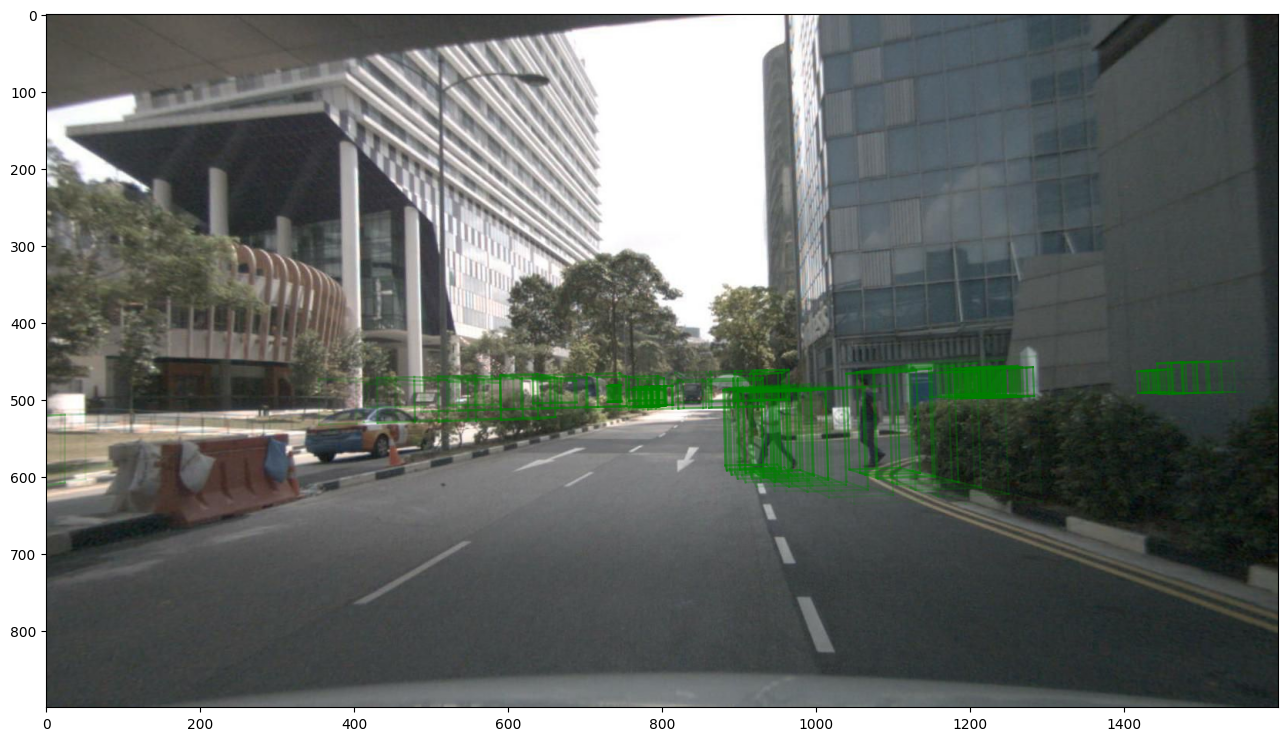

In [284]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.imshow(im)
height, width, _ = im.shape

for boxs in all_future_boxes: 
    for t, box in enumerate(boxs): 
        num_future_steps = len(boxs) 
        corners = box.corners() 
        corners = corners - ego_translation.reshape(3,1) 
        corners = ego_rotation.T @ corners 
        corners = corners - cs_translation.reshape(3,1) 
        corners = cs_rotation.T @ corners 
        
        pixels = view_points(corners, camera_intrinsic, normalize=True) 
        if np.all(pixels[0,:] < 0) or np.all(pixels[0,:] > width): 
            continue 
        if np.all(pixels[1,:] < 0) or np.all(pixels[1,:] > height): 
            continue 
            
        alpha = 0.5 - (t / num_future_steps) * .5
        edges = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)] 
        for i,j in edges: 
            x0 = np.clip(pixels[0,i], 0, width-1) 
            y0 = np.clip(pixels[1,i], 0, height-1) 
            x1 = np.clip(pixels[0,j], 0, width-1) 
            y1 = np.clip(pixels[1,j], 0, height-1) 
            ax.plot([x0, x1], [y0, y1], color='green', alpha=alpha)
plt.show()